In [1]:
import matplotlib.pyplot as plt
import statistics
import os
import sys
lib_path = os.path.abspath(os.path.join('..','..', '..', 'utils'))
sys.path.append(lib_path)
from GraphType import GraphStat
import readCSV as reader
import constants
import DistributionMetrics as metrics

In [2]:
def getModels(folderName, numberOfModels):
    filenames = reader.readmultiplefiles(folderName, numberOfModels, False)
    graphStats = [GraphStat(filename) for filename in filenames]
    return graphStats

## Import

In [33]:
domain = 'yakindumm'
mpc_guide = getModels('../input/{}/MPC/'.format(domain), 100)
na_guide = getModels('../input/{}/NodeActivity/'.format(domain), 100)
od_guide = getModels('../input/{}/OutDegree/'.format(domain), 100)
nt_guide = getModels('../input/{}/NodeType/'.format(domain), 100)
composite_guide = getModels('../input/{}/Composite/'.format(domain), 100)
composite_no_violations_guide = getModels('../input/{}/Composite_Without_Violations/'.format(domain), 100)
violations_guide = getModels('../input/{}/Violations/'.format(domain), 100)
human = getModels('../input/{}/Human/'.format(domain), 304)
model_types = [human, composite_guide, mpc_guide, na_guide, od_guide, nt_guide, composite_no_violations_guide, violations_guide]

In [34]:
type_map = {'Entry': 0.04257802080554814, 'Choice': 0.1267671379034409, 'State': 0.1596092291277674, 'Transition': 0.6138636969858629, 'Statechart': 0.010136036276340358, 'Region': 0.04467858095492131, 'Exit': 0.0018338223526273673, 'FinalState': 0.0005334755934915977}

In [35]:
# import rep
mpc_rep = getModels('../input/{}/MPC_REP/'.format(domain), 1)
na_rep = getModels('../input/{}/NA_REP/'.format(domain), 1)
od_rep = getModels('../input/{}/OUT_DEGREE_REP/'.format(domain), 1)
rep = mpc_rep[0]
rep.na = na_rep[0].na
rep.out_d = od_rep[0].out_d
rep.nodeTypeStat = type_map

### Helper Functions

In [36]:
def calculate_ks(dist1, dist2):
    value, p= metrics.ks_distance(dist1, dist2)
    return value

In [37]:
def mkdir(path):
    if not os.path.exists(path):
        os.makedirs(path)

### Plot Config

In [46]:
labels = ['human', 'combined', 'mpc', 'node activity', 'out degree', 'node type', 'combined_nv', 'violations']
output_path = '../output/{}/'.format(domain)
mkdir(output_path)

### Draw diagrams

In [47]:
def drawBoxDiagram(title, target, types, distance_func):
    distances = []
    for distributions in types:
        distances.append([distance_func(target, distribution) for distribution in distributions])
    fig, ax1 = plt.subplots()
    fig.set_size_inches(5, 4)
    ax1.set_xticklabels(labels, rotation=45, fontsize=15)
    #plt.title(title, fontsize=20)
    plt.boxplot(distances)
    plt.savefig('{}/{}.png'.format(output_path, title), dpi=500, bbox_inches="tight")

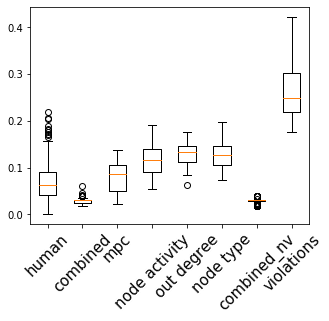

In [48]:
# draw mpc
mpc_types = []
for models in model_types:
        mpc_types.append([model.mpc for model in models])
drawBoxDiagram('MPC', rep.mpc, mpc_types, calculate_ks)

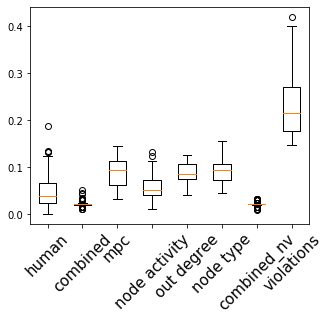

In [49]:
# draw node activity
na_types = []
for models in model_types:
        na_types.append([model.na for model in models])
drawBoxDiagram('Node_Activity', rep.na, na_types, calculate_ks)

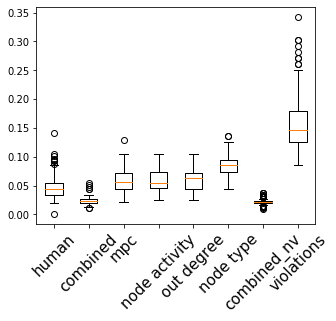

In [50]:
# draw out degree
out_d_types = []
for models in model_types:
        out_d_types.append([model.out_d for model in models])
drawBoxDiagram('Out_Degree', rep.out_d, out_d_types, calculate_ks)

In [51]:
def manual_ks(pdf1, pdf2):
    result = 0
    sum1 = 0
    sum2 = 0
    for(a, b) in zip(pdf1, pdf2):
        sum1 += a
        sum2 += b
        result = max(result, abs(sum1-sum2))
    return result


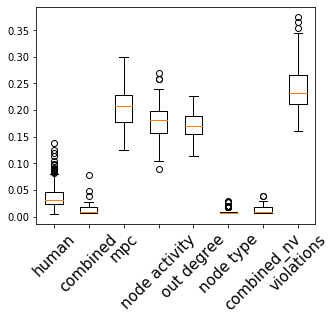

In [52]:
# draw node type
types = rep.nodeTypeStat.keys()
rep_type_dist = [float(rep.nodeTypeStat[key]) for key in types]
node_type_types = []
for models in model_types:
    type_dists = []
    for model in models:
        type_dists.append([float(model.nodeTypeStat.get(key, 0)) for key in types])
    node_type_types.append(type_dists)

#since we already know the pdf, we can compute the ks distance manually
drawBoxDiagram('Node_Type', rep_type_dist, node_type_types, manual_ks)

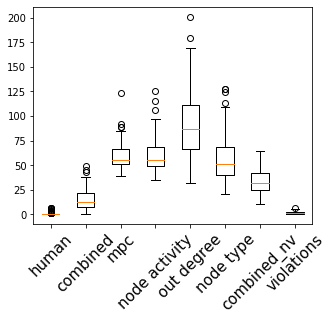

In [53]:
# draw violations
violation_types = []
for models in model_types:
        violation_types.append([model.violations for model in models])
drawBoxDiagram('Violations', None, violation_types, lambda a, b:b)